In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

In [2]:
path_datos = "../data/"
path = path_datos + "ZW2.msn_image.fits"
hdul = fits.open(path)

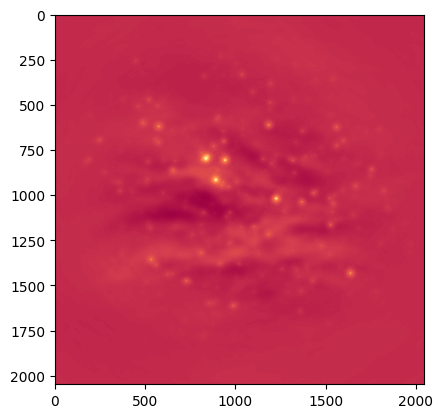

In [3]:
data=hdul[0].data[:50]
plt.imshow(data[0], cmap="Spectral")

In [4]:
# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor.txt", "r") as f:
    lines = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer a 1 un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1

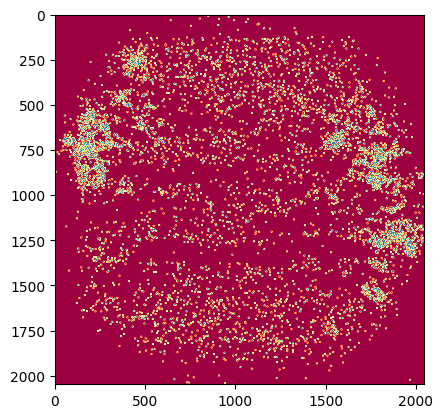

In [5]:
plt.imshow(label, cmap="Spectral")

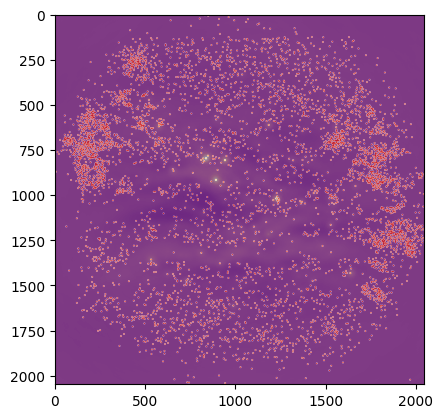

In [6]:
plt.imshow(data[0], cmap="Spectral")

# Dibujar el label superpuesto con transparencia
plt.imshow(label, cmap="coolwarm", alpha=0.5)

# Mostrar la imagen combinada
plt.show()

In [7]:
# Reformatear y normalizar las imágenes
input_data = np.array(data)
input_data = input_data.reshape((50, 2048, 2048, 1))
input_data = input_data.astype("float32") / 255.0

# Crear un array de salida repetido 50 veces (uno para cada imagen de entrada)
output_data = np.repeat(label[np.newaxis, :, :], 50, axis=0)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

In [11]:
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# Suponiendo que 'data' es tu array de imágenes originales de tamaño 50x2048x2048
# y que 'label' es tu etiqueta original de tamaño 2048x2048

# Redimensionar las imágenes de entrada y la etiqueta a un tamaño de 1024x1024
scaled_data = [resize(img, (1024, 1024), anti_aliasing=True) for img in data]
input_data = np.array(scaled_data)

scaled_label = resize(label, (1024, 1024), order=0, anti_aliasing=True, preserve_range=True)
scaled_label = np.round(scaled_label)

# Crear las etiquetas para cada imagen en el conjunto de datos
labels = np.array([scaled_label for _ in range(len(input_data))])

# Dividir los datos y las etiquetas en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(input_data, labels, test_size=0.2, random_state=42)

# A continuación, puedes continuar con la creación y entrenamiento de tu CNN

ModuleNotFoundError: No module named 'skimage'

In [ ]:

# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(2048, 2048, 1)))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entrenar el modelo
model.fit(x_train, y_train, epochs=10, batch_size=4, validation_data=(x_val, y_val))

Epoch 1/10


: 

: 